**Twitter Sentiment Analysis**

This notebook contains model which is able to differniate between positive and negative sentiment.

In [13]:
#Importing all the required libraries
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore", category=DeprecationWarning)


%matplotlib inline

In [14]:
#Loading of training dataset
train=pd.read_csv('Data/train_SentimentAnalysis.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [15]:
#Shape of training set
print("Shape of Training dataset:",train.shape)

Shape of Training dataset: (31962, 3)


In [16]:
#Loading of test dataset
test=pd.read_csv('Data/test_SentimentAnalysis.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [17]:
#Shape of test dataset
print("Shape of test dataset:",test.shape)

Shape of test dataset: (17197, 2)


In [18]:
#Combining test and training dataset for preprocessing
combine = train.append(test,ignore_index=True,sort=True)
combine.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


**Data Preprocessing**

In [19]:
#Defining function to remove user handle
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [20]:
#Removing all the user handle
combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [21]:
#Removing all the punctuations from the tweet
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ")

combine.head()

/var/folders/gx/ylg6zzl14_7d3n78jmqph8nc0000gn/T/ipykernel_82562/920142106.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z#]", " ")


,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [22]:
#Removing all the short words
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [23]:
#Tokenization of tweets
tokenized_tweet = combine['Tidy_Tweets'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: Tidy_Tweets, dtype: object

In [24]:
#Stemming of the tokenized tweeets
from nltk import PorterStemmer

ps = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x])

tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: Tidy_Tweets, dtype: object

In [25]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combine['Tidy_Tweets'] = tokenized_tweet
combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus they offer wheelchair ...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


In [26]:
#Importing all the required library for visualization of words
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

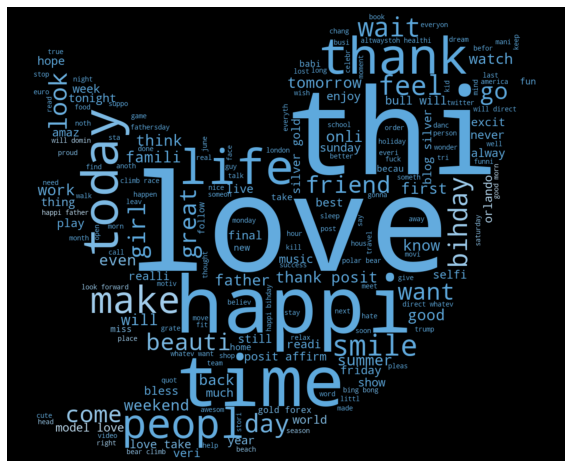

In [27]:
#Visualization of positive words using WordCloud
all_words_positive = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==0])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_positive)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

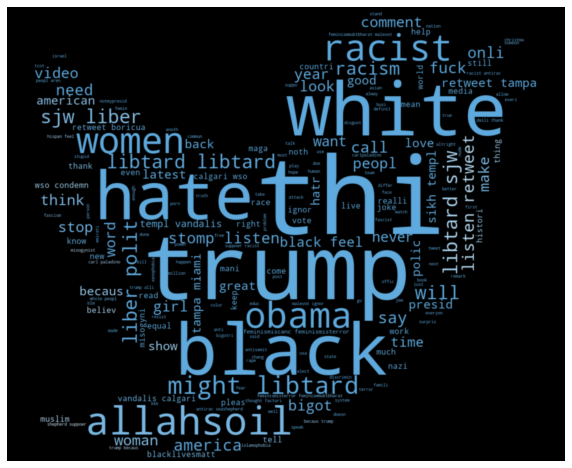

In [28]:
#Visualiztion of negative words using WordCloud
all_words_negative = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==1])

# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_negative)

# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="gaussian")

plt.axis('off')
plt.show()

In [29]:
#Function to extract hashtags from tweet
def Hashtags_Extract(x):
    hashtags=[]
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

In [30]:
ht_positive = Hashtags_Extract(combine['Tidy_Tweets'][combine['label']==0])

In [31]:
ht_positive_unnest = sum(ht_positive,[])

In [32]:
ht_negative = Hashtags_Extract(combine['Tidy_Tweets'][combine['label']==1])

In [33]:
ht_negative_unnest = sum(ht_negative,[])

In [34]:
#Word frequency for positive words
word_freq_positive = nltk.FreqDist(ht_positive_unnest)

word_freq_positive

FreqDist({'love': 1654, 'posit': 917, 'smile': 676, 'healthi': 573, 'thank': 534, 'fun': 463, 'life': 425, 'affirm': 423, 'summer': 390, 'model': 375, ...})

In [35]:
#Creating dataframe for most used positive words
df_positive = pd.DataFrame({'Hashtags':list(word_freq_positive.keys()),'Count':list(word_freq_positive.values())})

df_positive.head()

,Hashtags,Count
0,run,72
1,lyft,2
2,disapoint,1
3,getthank,2
4,model,375


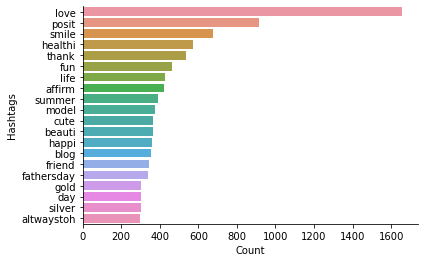

In [36]:
#Bar plot for 10 most used positive words
df_positive_plot = df_positive.nlargest(20,columns='Count') 
sns.barplot(data=df_positive_plot,y='Hashtags',x='Count')
sns.despine()

In [37]:
#Counting the frequency for 10 most used negative words
word_freq_negative = nltk.FreqDist(ht_negative_unnest)

word_freq_negative

FreqDist({'trump': 136, 'polit': 95, 'allahsoil': 92, 'liber': 81, 'libtard': 77, 'sjw': 75, 'retweet': 63, 'black': 46, 'miami': 46, 'hate': 37, ...})

In [38]:
#Creating dataframe for most used negative words
df_negative = pd.DataFrame({'Hashtags':list(word_freq_negative.keys()),'Count':list(word_freq_negative.values())})

df_negative.head()

,Hashtags,Count
0,cnn,10
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,5


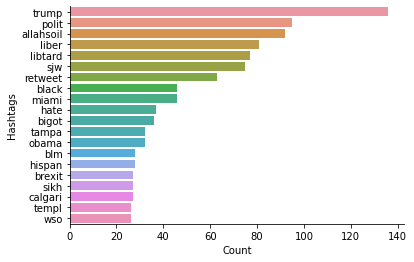

In [39]:
#Plotting graph for 10 most used negative words
df_negative_plot = df_negative.nlargest(20,columns='Count') 
sns.barplot(data=df_negative_plot,y='Hashtags',x='Count')
sns.despine()

In [40]:
#Extracting features from cleaned tweets
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combine['Tidy_Tweets'])

df_bow = pd.DataFrame(bow.todense())

df_bow

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#Extracting from the TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(combine['Tidy_Tweets'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Applying Various Machine Learning Models**

In [42]:
train_bow = bow[:31962]

train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [43]:
train_tfidf_matrix = tfidf_matrix[:31962]

train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
#Spliting into training and testing data(Bag of words)
x_train_bow,x_valid_bow,y_train_bow,y_valid_bow = train_test_split(train_bow,train['label'],test_size=0.3,random_state=2)

In [45]:
#Spliting into training and testing data(TF-IDF)
x_train_tfidf,x_valid_tfidf,y_train_tfidf,y_valid_tfidf = train_test_split(train_tfidf_matrix,train['label'],test_size=0.3,random_state=17)

In [46]:
#Applying Logistic Regression model on the given data set
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')

# Fitting the Logistic Regression Model

Log_Reg.fit(x_train_bow,y_train_bow)

LogisticRegression(random_state=0)

In [47]:
# The first part of the list is predicting probabilities for label:0 
# and the second part of the list is predicting probabilities for label:1
prediction_bow = Log_Reg.predict_proba(x_valid_bow)

prediction_bow

array([[9.86501156e-01, 1.34988440e-02],
       [9.99599096e-01, 4.00904144e-04],
       [9.13577383e-01, 8.64226167e-02],
       ...,
       [8.95457155e-01, 1.04542845e-01],
       [9.59736065e-01, 4.02639345e-02],
       [9.67541420e-01, 3.24585797e-02]])

In [48]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_bow[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_bow = f1_score(y_valid_bow, prediction_int)

log_bow

0.5721352019785655

In [49]:
#Using TF-IDF features
Log_Reg.fit(x_train_tfidf,y_train_tfidf)

LogisticRegression(random_state=0)

In [50]:
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_tfidf

array([[0.98487907, 0.01512093],
       [0.97949889, 0.02050111],
       [0.9419737 , 0.0580263 ],
       ...,
       [0.98630906, 0.01369094],
       [0.96746188, 0.03253812],
       [0.99055287, 0.00944713]])

In [51]:
#Calculating f1 score
prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int)

log_tfidf

0.5862068965517241

In [52]:
#Using XGBoost classifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)
model_bow.fit(x_train_bow, y_train_bow)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.9, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=22, ...)

In [53]:
# The first part of the list is predicting probabilities for label:0 
# and the second part of the list is predicting probabilities for label:1
xgb=model_bow.predict_proba(x_valid_bow)

xgb

array([[9.9109417e-01, 8.9058345e-03],
       [9.9910688e-01, 8.9310389e-04],
       [9.2758572e-01, 7.2414286e-02],
       ...,
       [8.9067906e-01, 1.0932093e-01],
       [9.2758572e-01, 7.2414286e-02],
       [9.2758572e-01, 7.2414286e-02]], dtype=float32)

In [54]:
#Calculating f1 score
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
xgb=xgb[:,1]>=0.3

# converting the results to integer type
xgb_int=xgb.astype(np.int)

# calculating f1 score
xgb_bow=f1_score(y_valid_bow,xgb_int)

xgb_bow

0.5811023622047244

In [55]:
#Using TF-IDF features
model_tfidf=XGBClassifier(random_state=29,learning_rate=0.7)
model_tfidf.fit(x_train_tfidf, y_train_tfidf)

# The first part of the list is predicting probabilities for label:0 
# and the second part of the list is predicting probabilities for label:1
xgb_tfidf=model_tfidf.predict_proba(x_valid_tfidf)

xgb_tfidf

array([[0.9958908 , 0.00410918],
       [0.9872918 , 0.01270822],
       [0.9527768 , 0.04722321],
       ...,
       [0.99192214, 0.00807783],
       [0.9852176 , 0.01478244],
       [0.9974108 , 0.0025892 ]], dtype=float32)

In [56]:
#Calculating f1 score
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
xgb_tfidf=xgb_tfidf[:,1]>=0.3

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf.astype(np.int)

# calculating f1 score
score=f1_score(y_valid_tfidf,xgb_int_tfidf)

score

0.5792

In [57]:
#Applying Decision Tree model
dct = DecisionTreeClassifier(criterion='entropy', random_state=1)
dct.fit(x_train_bow,y_train_bow)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [58]:
#Prediction using Decision trees
dct_bow = dct.predict_proba(x_valid_bow)

dct_bow

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [59]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_bow=dct_bow[:,1]>=0.3

# converting the results to integer type
dct_int_bow=dct_bow.astype(np.int)

# calculating f1 score
dct_score_bow=f1_score(y_valid_bow,dct_int_bow)

dct_score_bow

0.5141776937618148

In [60]:
#Using TF-IDF features
dct.fit(x_train_tfidf,y_train_tfidf)

DecisionTreeClassifier(criterion='entropy', random_state=1)

In [61]:
#Prediction using Decision Tree(TF-IDF features)
dct_tfidf = dct.predict_proba(x_valid_tfidf)

dct_tfidf

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [62]:
#Calculating f1 score
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf)

dct_score_tfidf

0.5498821681068342

**Model Comparision**

In [63]:
Algo=['LogisticRegression(Bag-of-Words)','XGBoost(Bag-of-Words)','DecisionTree(Bag-of-Words)','LogisticRegression(TF-IDF)','XGBoost(TF-IDF)','DecisionTree(TF-IDF)']
score = [log_bow,xgb_bow,dct_score_bow,log_tfidf,score,dct_score_tfidf]

compare=pd.DataFrame({'Model':Algo,'F1_Score':score},index=[i for i in range(1,7)])
compare.T

,1,2,3,4,5,6
Model,LogisticRegression(Bag-of-Words),XGBoost(Bag-of-Words),DecisionTree(Bag-of-Words),LogisticRegression(TF-IDF),XGBoost(TF-IDF),DecisionTree(TF-IDF)
F1_Score,0.572135,0.581102,0.514178,0.586207,0.5792,0.549882


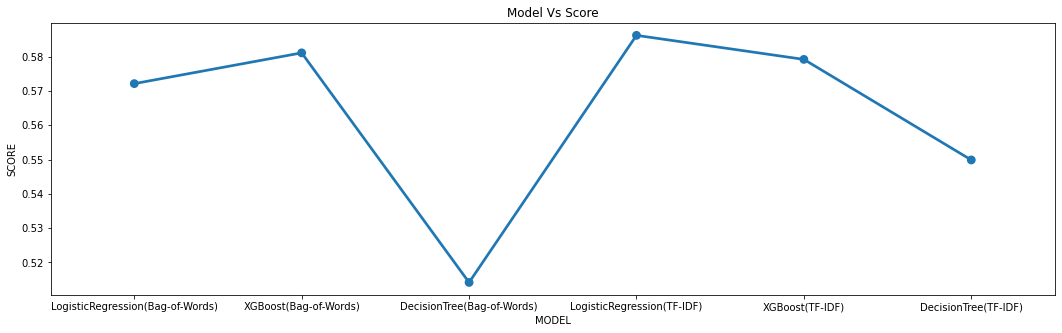

In [64]:
#Plotting the f1 score for different models
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare)

plt.title('Model Vs Score')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

From the above comparsion, it is clear that logistic regression is the best model using the TF-IDF features.

In [65]:
test_tfidf = tfidf_matrix[31962:]

test_pred = Log_Reg.predict_proba(test_tfidf)

test_pred_int = test_pred[:,1] >= 0.3

test_pred_int = test_pred_int.astype(np.int)

test['label'] = test_pred_int

test_pred_ = test[['id','label']]

test_pred_

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0
